In [1]:
import re
import io
import sys
import nltk
import random
import string, os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU, Bidirectional
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")

2022-12-16 00:47:31.718651: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-16 00:47:31.718790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
lyrics = pd.read_csv("/kaggle/input/english-melody-songs/English_Songs.csv",encoding='latin1')
lyrics.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [3]:
print("Size of Dataset:",lyrics.shape)

Size of Dataset: (764, 3)


In [4]:
lyrics["No_of_Characters"] = lyrics["Lyrics"].apply(len)
lyrics["No_of_Words"]=lyrics.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
lyrics["No_of_Lines"] = lyrics["Lyrics"].str.split('\n').apply(len)

In [5]:
lyrics.describe()

,No_of_Characters,No_of_Words,No_of_Lines
count,764.000000,764.000000,764.000000
mean,1405.732984,318.128272,46.195026
std,664.105677,153.510914,21.023233
min,3.000000,1.000000,1.000000
25%,949.750000,215.000000,32.750000
50%,1289.500000,290.000000,44.000000
75%,1712.250000,387.250000,56.000000
max,7275.000000,1652.000000,224.000000


<Figure size 1080x1080 with 0 Axes>

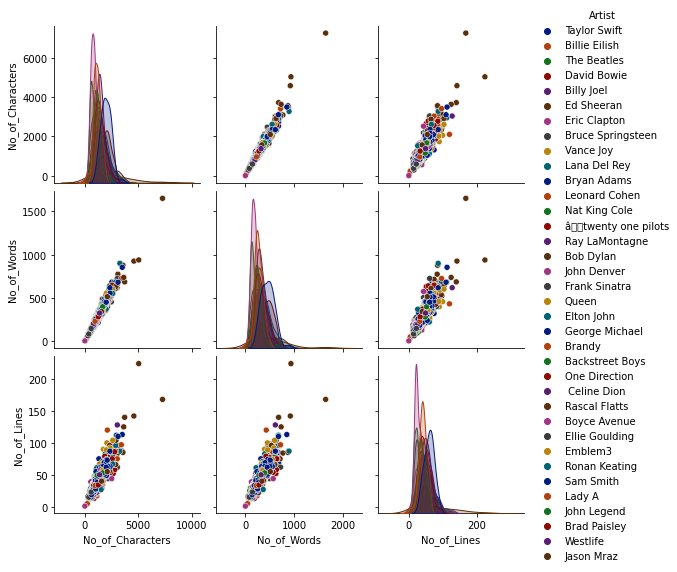

In [6]:
# Plotting the no of songs by artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(lyrics, hue="Artist", palette="dark")

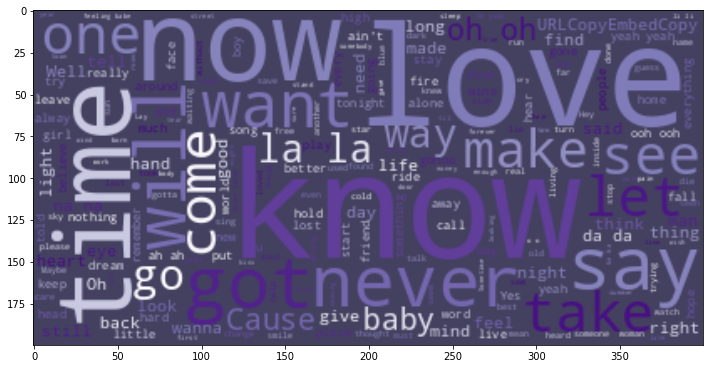

In [7]:
# Most of the Frequent Words in songs
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(lyrics["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [8]:
Corpus =''
for listitem in lyrics.Lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 98


In [9]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '\x80', '\x81', '\x83', '\x84', '\x85', '\x88', '\x8a', '\x8b', '\x8f', '\x93', '\x94', '\x98', '\x99', '\x9a', '\x9c', '\x9d', '\x9f', '\xa0', '¡', '¤', '¦', '§', '¨', '©', 'ª', '«', '\xad', '±', '³', 'µ', '¶', '»', '¼', '¿', 'â', 'ã', 'å', 'ï', 'ð', 'ø', 'ù']


In [10]:
to_remove = ['\x81',
 '¦',
 '\x9a',
 '}',
 '\x9d',
 'ª',
 'ã',
 '\x98',
 '»',
 '¿',
 '-',
 '\x93',
 'ð',
 '{',
 '!',
 '\x9c',
 '±',
 '³',
 'ï',
 '*',
 '\x8a',
 'â',
 'å',
 'µ',
 '\x83',
 ')',
 '\x9f',
 '(',
 '\x85',
 '¼',
 '\xad',
 '\x84',
 '\x99',
 '\x8f',
 '\x94',
 '~',
 '\x80',
 '\x88',
 '¤',
 '¶',
 '&',
 'ù',
 'ø',
 '©',
 '/',
 '\x8b',
 '\xa0',
 '¡',
 '¨',
 '§',
 '«']
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

In [11]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
symbols = sorted(list(set(Corpus)))

corpus_length = len(Corpus)  # length of corpus
num_unique_symbols = len(symbols)  # number of unique characters

# create a dictionary to access the vocabulary from indices and vice versa
mapping = {c: i for i, c in enumerate(symbols)}
reverse_mapping = {i: c for i, c in enumerate(symbols)}

print(f"Total number of characters: {corpus_length}")
print(f"Number of unique characters: {num_unique_symbols}")

Total number of characters: 1073980
Number of unique characters: 47


In [13]:
#Splitting the Corpus in equal length of strings and output target
length = 100
features = []
targets = []
for i in range(0, corpus_length - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 1073880


In [14]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(num_unique_symbols)

In [15]:
# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets)

In [16]:
X_temp,X_test,y_temp,y_test = train_test_split(X,y,test_size = 0.1,random_state = 42)

In [17]:
X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,random_state = 42)

In [18]:
print("Train Size",len(X_train))
print("Test Size",len(X_test))
print("Validation Size",len(X_val))

Train Size 773193
Test Size 107388
Validation Size 193299


In [19]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-12-16 00:48:13.353492: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-16 00:48:13.356751: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-16 00:48:13.356788: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 00:48:13.356857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8e91ab0036fd): /proc/driver/nvidia/version does not exist
2022-12-16 00:48:13.361422: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [20]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
check_point = tf.keras.callbacks.ModelCheckpoint(filepath='Final_GRU_2_model.h5', verbose=1, save_weights_only=False, monitor='accuracy', mode='max')

In [21]:
with tpu_strategy.scope():
    #Initialising the Model
    model = Sequential()
    model.add(GRU(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(GRU(128))
    model.add(Dense(y.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics = ["accuracy"])

#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 256)          198912    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 47)                6063      
Total params: 353,199
Trainable params: 353,199
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Training the Model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=20, callbacks = [earlystopping,check_point])

Epoch 1/20
6041/6041 [==============================] - 142s 23ms/step - loss: 2.6242 - accuracy: 0.2538 - val_loss: 2.1002 - val_accuracy: 0.3874

Epoch 00001: saving model to Final_GRU_2_model.h5
Epoch 2/20
6041/6041 [==============================] - 136s 22ms/step - loss: 2.0337 - accuracy: 0.4102 - val_loss: 1.9092 - val_accuracy: 0.4439

Epoch 00002: saving model to Final_GRU_2_model.h5
Epoch 3/20
6041/6041 [==============================] - 137s 23ms/step - loss: 1.8710 - accuracy: 0.4529 - val_loss: 1.8098 - val_accuracy: 0.4710

Epoch 00003: saving model to Final_GRU_2_model.h5
Epoch 4/20
6041/6041 [==============================] - 138s 23ms/step - loss: 1.7770 - accuracy: 0.4778 - val_loss: 1.7447 - val_accuracy: 0.4892

Epoch 00004: saving model to Final_GRU_2_model.h5
Epoch 5/20
6041/6041 [==============================] - 137s 23ms/step - loss: 1.7151 - accuracy: 0.4946 - val_loss: 1.7145 - val_accuracy: 0.4978

Epoch 00005: saving model to Final_GRU_2_model.h5
Epoch 6/20

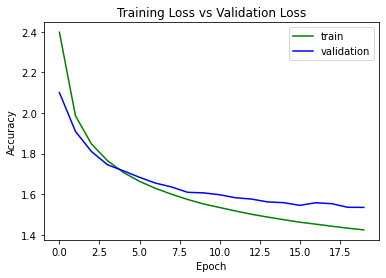

In [23]:
#Loss Plot of training and validation
plt.plot()
plt.title('Training Loss vs Validation Loss')
plt.plot(history.history['loss'], color = 'green', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

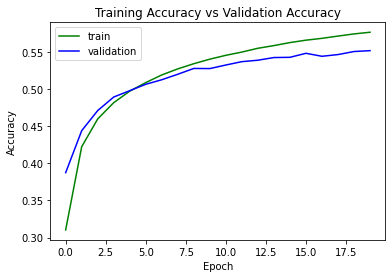

In [24]:
#Accuracy Plot of training and validation
plt.plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(history.history['accuracy'], color = 'green', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(num_unique_symbols)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [27]:
#Generating a song from the model
song_1 = Lyrics_Generator("me and my love partying at night", 200)
#Let's have a look at the song
song_1

'me and my love partying at night\ni was born to be a long love\n\nand i know i know you want\nto love you well, you know i know you want to be a long love\n\nand i know i know you want\nto love you well, you know i know you want to be a lo'